# DES Simulation

This notebook generates the results used in the report for the second assignment of the course 'Stochastic Simulation'.

Authors:

1. Divyaben Hasmukhbhai Gajera
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: divya.gajera@student.uva.nl
- Student Number: 14932644

2. K. López
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: kenia.lopez.sotomayor@student.uva.nl
- Student Number: 12965081

3. T. P. Glansdorp
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: thomas.glansdorp@student.uva.nl
- Student Number: 12748587

In [8]:
import simpy as sp
import numpy as np
import matplotlib.pyplot as plt
import random
import queue

## DES program that implements FIFO scheduling case

In [96]:
class MMnFIFOQueue:
    def __init__(self, env, arrival_rate, service_rate, n):
        self.env = env
        self.server = sp.Resource(env, capacity=n)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.queue = []

        env.process(self.arrive())
        

    def arrive(self):
        customer_count = 0
        while True:
            inter_arrival_time = random.expovariate(self.arrival_rate)
            yield self.env.timeout(inter_arrival_time)
            self.queue.append(self.env.now)
            customer_count += 1
            self.env.process(self.depart(customer_count))
            print(f"Customer {customer_count} arrived at {self.env.now}")

            
    def depart(self, customer_count):
        print(self.queue)
        with self.server.request() as request:
            yield request
            service_time = random.expovariate(self.service_rate)
            yield self.env.timeout(service_time)
            self.queue.pop(0)
            print(f"Customer {customer_count} departed at {self.env.now} with wait_time of {service_time}")


def run_MMn_FIFO_queue(arrival_rate, service_rate, n, simulation_time):
    env = sp.Environment()
    mmn_queue = MMnFIFOQueue(env, arrival_rate, service_rate, n)
    env.run(until=simulation_time)


In [97]:
arrival_rate = 2.0
service_rate = 3.0
simulation_time = 10.0
n = 2

run_MMn_FIFO_queue(arrival_rate, service_rate, n, simulation_time)

Customer 1 arrived at 1.1031092715306303
[1.1031092715306303]
Customer 2 arrived at 1.2700232264634765
[1.1031092715306303, 1.2700232264634765]
Customer 2 departed at 1.2946491980845236 with wait_time of 0.024625971621047155
Customer 3 arrived at 1.3379541421687091
[1.2700232264634765, 1.3379541421687091]
Customer 1 departed at 1.3621056321428375 with wait_time of 0.25899636061220715
Customer 4 arrived at 1.3693797031676418
[1.3379541421687091, 1.3693797031676418]
Customer 4 departed at 1.4111208007265923 with wait_time of 0.041741097558950495
Customer 3 departed at 1.7173676497368666 with wait_time of 0.37941350756815745
Customer 5 arrived at 2.986798564406796
[2.986798564406796]
Customer 5 departed at 3.0565571232605255 with wait_time of 0.06975855885372978
Customer 6 arrived at 3.8823950220388235
[3.8823950220388235]
Customer 7 arrived at 3.9115469834380003
[3.8823950220388235, 3.9115469834380003]
Customer 8 arrived at 3.9128814111940082
[3.8823950220388235, 3.9115469834380003, 3.91

In [7]:
import simpy as sp
import random
import pandas as pd
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt

In [25]:
class g:
    arrival_rate = 1
    service_rate = 2
    number_of_servers = 1
    sim_duration = 200
    number_of_runs = 10

class Customer:
    def __init__(self, customer_id):
        self.id = customer_id
        self.queue_time = 0

class Queue:
    
    def __init__(self, run_number, queue_type):
        self.env = sp.Environment()
        self.server = sp.Resource(self.env, capacity=g.number_of_servers)
        self.run_number = run_number
        self.queue_type = queue_type
        self.customer_counter = 0
        self.mean_queue_time = 0
        self.mean_system_time = 0
        self.mean_service_time = 0
        #self.file_name = file_name
        columns = ["Customer ID", "Start Queueing", "End Queueing", "Queueing Time", "Sojourn Time", "Service Time"] 
        self.results_df = pd.DataFrame(columns=columns)
        self.results_df.set_index("Customer ID", inplace=True)
        
    
    # Method that generates customers arrivals
    def generate_arrivals(self):
        while True:
            self.customer_counter += 1
            cp = Customer(self.customer_counter)
            # Run activity generator for this customer
            self.env.process(self.create_queue(cp))

            # sample time until next customer
            t = random.expovariate(g.arrival_rate)

            # Freeze untill that time has passed
            yield self.env.timeout(t)
            
    def create_queue(self, customer):
        start_queue = self.env.now
        
        # Request a server
        with self.server.request() as req:
            # Freeze until the request can be met 
            yield req
            
            # Sample time spent in server
            if self.queue_type == "MMn":
                sampled_service_time = random.expovariate(g.service_rate)
            elif self.queue_type == "MDn":
                sampled_service_time = 2
            
            end_queue = self.env.now
            
            # Freeze until that time has passed
            yield self.env.timeout(sampled_service_time)
            
            # Calculate time customer was queueing
            out_of_system = self.env.now
            sojourn_time = out_of_system - start_queue
            customer.queue_time = end_queue - start_queue
            df_to_add = pd.DataFrame({"Customer ID":[customer.id], "Start Queueing": [start_queue],
                                     "End Queueing": [end_queue], "Queueing Time": [customer.queue_time],
                                     "Sojourn Time": [sojourn_time], "Service Time":[sampled_service_time]})
            df_to_add.set_index("Customer ID", inplace=True)
            self.results_df = df_to_add
            
    def calculate_mean_times(self):
        self.mean_queue_time = self.results_df["Queueing Time"].mean()
        self.mean_system_time = self.results_df["Sojourn Time"].mean()
        self.mean_service_time = self.results_df["Service Time"].mean()
        
    def write_run_results(self):
        with open(self.file_name, "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [self.run_number, self.mean_queue_time]
            writer.writerow(results_to_write)
            
    def run(self):
        self.env.process(self.generate_arrivals())
        self.env.run(until=g.sim_duration)
        # Calculate run results
        self.calculate_mean_times()
        #self.write_run_results()
        

In [10]:
def calculate_CI(data):
    
    sigma = data.std()
    x_bar = data.mean()
    CI = (x_bar - (1.96*sigma/np.sqrt(data.shape[0])), x_bar + (1.96*sigma/np.sqrt(data.shape[0])))
    
    return CI

In [17]:
def estimate_waiting_times(type_queue, RHO, MU, n):
    
    mean_queue = []
    mean_sojourn = []
    mean_service = []
    for rho in RHO:
        temp_mean_queue_run = []
        temp_sj = []
        temp_serice = []
        g.arrival_rate = MU*rho
        g.service_rate = MU
        g.number_of_servers = n
        g.number_of_runs = 100
        for run in range(g.number_of_runs):
            queue_model = Queue(run, type_queue)
            queue_model.run()
            temp_mean_queue_run.append(queue_model.mean_queue_time)
            temp_sj.append(queue_model.mean_system_time)
            temp_serice.append(queue_model.mean_service_time)




        mean_queue.append(np.array(temp_mean_queue_run).mean(axis=0))
        mean_sojourn.append(np.array(temp_sj).mean(axis = 0))
        mean_service.append(np.array(temp_serice).mean(axis=0))
    
    return mean_queue, mean_sojourn, mean_service

In [133]:
#Null hypothesis: The mean queueing time for n=1 < n=2 

def test_estimate_waiting_times(type_queue, RHO, MU, n):
    
    #

    global_mean_queue_run = []
    global_sj = []
    global_service = []
    for rho in RHO:
        g.arrival_rate = MU*rho
        g.service_rate = MU
        g.number_of_servers = n
        g.number_of_runs = 100


        temp_mean_queue_run = []
        temp_sj = []
        temp_service = []
        for run in range(g.number_of_runs):
            queue_model = Queue(run, type_queue)
            queue_model.run()
            temp_mean_queue_run.append(queue_model.mean_queue_time)
            temp_sj.append(queue_model.mean_system_time)
            temp_service.append(queue_model.mean_service_time)
        
        global_mean_queue_run.append(np.array(temp_mean_queue_run))
        global_sj.append(np.array(temp_sj))
        global_service.append(np.array(temp_service))
    
    return np.array(global_mean_queue_run), np.array(global_sj), np.array(global_service)


In [225]:
MU = 4
RHO = [0.1, 0.2,0.3, 0.4, 0.45, 0.55, 0.6, 0.65,0.7,0.725, 0.75, 0.8,0.825, 0.85, 0.9, 0.925,0.95, 0.975,1.0, 1.1,1.2]
num_sim = [5, 10, 25, 50, 100, 150, 500, 1000]

In [206]:
tem_q_time, temp_sj_time, temp_serv_time = test_estimate_waiting_times("MMn", RHO, MU, 1)
tem_q_time2, temp_sj_time2, temp_serv_time2 = test_estimate_waiting_times("MMn", RHO, MU/2, 2)
tem_q_time4, temp_sj_time4, temp_serv_time4 = test_estimate_waiting_times("MMn", RHO, MU/2, 4) #Divide by two because we want a fair comparison

[[Ellipsis], [Ellipsis], Ellipsis]


In [137]:

# Save as pickle
import pickle

with open("MMn_1_server.pkl", "wb") as f:
    pickle.dump(tem_q_time, f)

with open("MMn_2_server.pkl", "wb") as f:
    pickle.dump(tem_q_time2, f)
    

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.50437808e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.98055326e-02]
 [4.28279820e-01 0.00000000e+00 6.06340706e-01 ... 3.87987708e-01
  6.96289217e-01 4.27338021e-01]
 ...
 [5.81978475e+00 2.87459075e+00 1.22736590e+01 ... 1.69115715e+01
  8.00043493e-01 5.85171953e-01]
 [2.45383106e+00 1.14985472e+01 2.87688476e+01 ... 3.01959316e+01
  4.84183621e+00 2.76843740e+00]
 [2.66595465e+01 3.87589961e+01 1.34873164e+01 ... 3.30701441e+01
  2.60765399e+01 3.40578049e+01]]
[26.65954655 38.75899613 13.4873164  37.80656404 48.4442473  25.63307157
 31.06157043 35.0710837  23.4112426  28.91114738 33.87531828 37.68681362
 46.64393974 28.35539289 30.78729966 36.74869904 41.86563663 30.79991552
 35.4891053  38.58479084 36.80768866 35.00271799 29.17316287 37.76340697
 21.93963328 37.52732565 16.4126454  26.8610045  32.62793764 36.90465764
 32.54320963 15.49459692 36.9926903

In [211]:

import scipy.stats as stats


def stat_significance(tem_q_time, tem_q_time2):
    # H0: t1 < t2
    
    for i in range(len(tem_q_time)):
        values1 = tem_q_time[i,:]
        values2 = tem_q_time2[i,:]
     
        t_stat, p_value = stats.ttest_ind(values1, values2, alternative="greater") #ALternative = greater means that waiting time t1 > t2

        if p_value < 0.05:
            print("Reject null hypothesis")
            print(p_value)

        else:    
            print("Accept null hypothesis")


# Load the pickle
with open('MMn_1_server.pkl', 'rb') as f:
    tem_q_time = pickle.load(f)

with open('MMn_2_server.pkl', 'rb') as f:
    tem_q_time2 = pickle.load(f)

stat_significance(tem_q_time, tem_q_time2)

Reject null hypothesis
0.001815166515031325
Reject null hypothesis
0.000463323192235478
Reject null hypothesis
8.866380467958275e-06
Reject null hypothesis
0.0008796815351029757
Reject null hypothesis
4.166981139175153e-06
Reject null hypothesis
0.00028345055339129826
Reject null hypothesis
1.2069283470797387e-07
Reject null hypothesis
3.3372473791767966e-07
Reject null hypothesis
1.088335887899575e-09
Reject null hypothesis
2.1179524847109278e-07
Reject null hypothesis
3.797569053813852e-09
Reject null hypothesis
3.3848274720257594e-09
Reject null hypothesis
1.6788257320131547e-12
Reject null hypothesis
3.629642177047492e-11
Reject null hypothesis
4.7973714132132866e-20
Reject null hypothesis
1.3779802444843008e-16
Reject null hypothesis
2.949662375544979e-16
Reject null hypothesis
1.3094330581166436e-20
Reject null hypothesis
1.9693470234396794e-25
Reject null hypothesis
6.160940198911318e-54
Reject null hypothesis
4.122218776304025e-99


In [221]:
with open('MMn_1_server.pkl', 'rb') as f:
    tem_q_time = pickle.load(f)

with open('MMn_2_server.pkl', 'rb') as f:
    tem_q_time2 = pickle.load(f)



  0%|          | 0/21 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 21/21 [07:08<00:00, 20.41s/it]


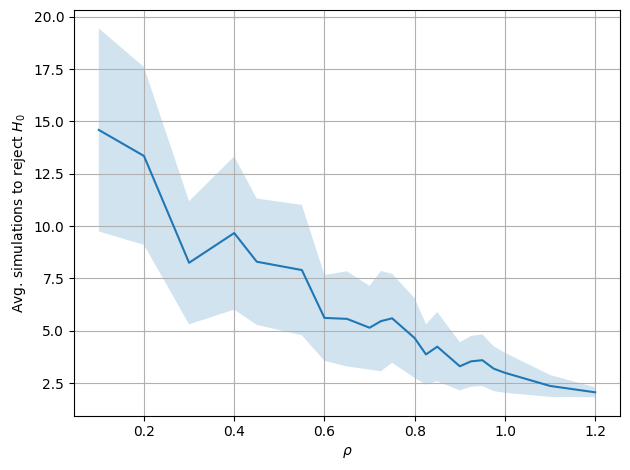

In [230]:
import pickle
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numba
from tqdm import tqdm


@numba.jit(nopython=True)
def bootstrap(data, replacement, num_samples):
    """Returns bootstrap sample from data."""
    idx = np.random.choice(len(data), (num_samples), replace=replacement)
    return data[idx]


def num_sim_for_statistical_significance():

    num_sim_for_rho = np.zeros((len(tem_q_time), 1000))

    for i in tqdm(range(len(tem_q_time))):  # For each rho

        for j in range(1000):
            rejected = False
            count = 0
            while not rejected:
                count += 1
                values1 = bootstrap(tem_q_time[i], True, count).flatten()
                values2 = bootstrap(tem_q_time2[i], True, count).flatten()

                # ALternative = greater means that waiting time t1 > t2
                t_stat, p_value = stats.ttest_ind(
                    values1, values2, alternative="greater")

                if p_value < 0.05:
                    num_sim_for_rho[i, j] = count
                    rejected = True
    return num_sim_for_rho


# Load the pickle
with open("MMn_1_server.pkl", "rb") as f:
    tem_q_time = pickle.load(f)

with open("MMn_2_server.pkl", "rb") as f:
    tem_q_time2 = pickle.load(f)

RHO = [0.1, 0.2, 0.3, 0.4, 0.45, 0.55, 0.6, 0.65, 0.7, 0.725,
       0.75, 0.8, 0.825, 0.85, 0.9, 0.925, 0.95, 0.975, 1.0, 1.1, 1.2]

rejection_numbers_per_rho = num_sim_for_statistical_significance()

# Plot the rejection numbers per rho
# Take mean and fill between std.
means = [np.mean(x) for x in rejection_numbers_per_rho]
std = [np.std(x) for x in rejection_numbers_per_rho]

plt.plot(RHO, means)
plt.fill_between(RHO, np.array(means)-np.array(std),
                 np.array(means)+np.array(std), alpha=0.2)
plt.xlabel(r"$\rho$")
plt.ylabel(r"Avg. simulations to reject $H_0$")
plt.grid()

plt.tight_layout()
plt.savefig("bootstrap.png")

plt.show()




In [26]:
est_mean, est_sojourn, est_service = estimate_waiting_times("MMn", RHO, MU, 1)

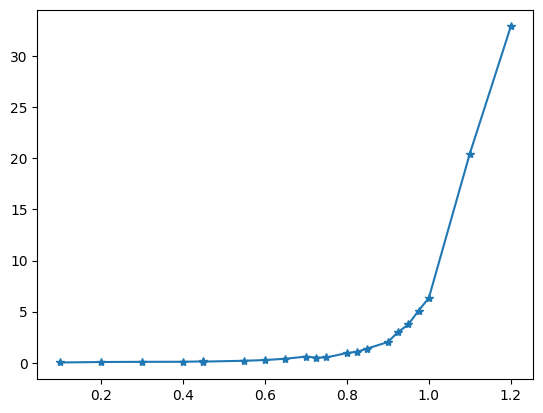

In [27]:
plt.plot(RHO, np.array(est_mean), "*-")

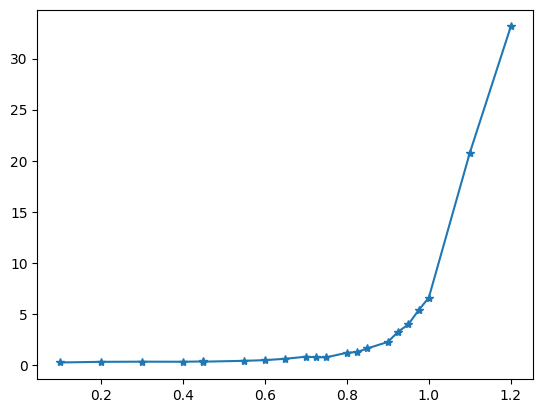

In [28]:
plt.plot(RHO, np.array(est_sojourn), "*-")

In [29]:
est_mean_2, est_sojourn_2, est_service_2 = estimate_waiting_times("MMn", RHO, MU, 2)
    

In [30]:
est_mean_4, est_sojourn_4, est_service_4 = estimate_waiting_times("MMn", RHO, MU, 4)

Text(0, 0.5, 'Avg Waiting Time')

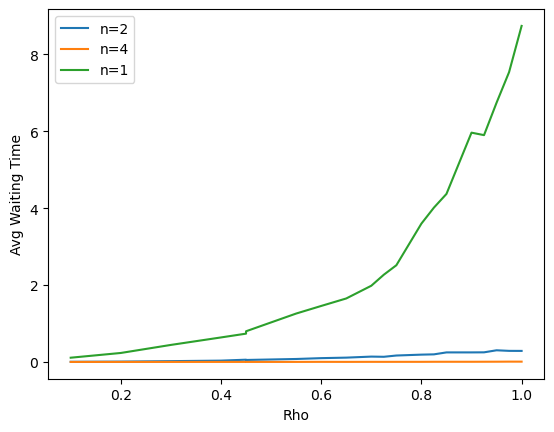

In [79]:
plt.plot(RHO[:-2], est_mean_2[:-2], label="n=2")
plt.plot(RHO[:-2], est_mean_4[:-2], label="n=4")
plt.plot(RHO[:-2], est_mean[:-2], label="n=1")
plt.legend()
plt.xlabel("Rho")
plt.ylabel("Avg Waiting Time")

### Statistical significance 

### Numer of measurements required

## DES program that implements shortest job first case for M/M/1

In [5]:
class SJF_queue:
    
    def __init__(self, run_number):
        self.env = sm.Environment()
        self.customer_counter = 0
        self.server = sm.PriorityResource(self.env, capacity=g.number_of_servers)
        self.run_number = run_number
        self.mean_queue_time = 0
        self.results_df = pd.DataFrame()
        self.results_df["Customer ID"] = []
        self.results_df["Start Queueing"] = []
        self.results_df["End Queueing"] = []
        self.results_df["Queueing Time"] = []
        self.results_df.set_index("Customer ID", inplace=True)
        
    
    # Method that generates customers arrivals
    def generate_arrivals(self):
        while True:
            self.customer_counter += 1
            cp = Customer(self.customer_counter)
            # Run activity generator for this customer
            self.env.process(self.create_queue(cp))

            # sample time until next customer
            t = random.expovariate(1.0/g.arrival_rate)

            # Freezr untill that time has passed
            yield self.env.timeout(t)
            
    def create_queue(self, customer):
        start_queue = self.env.now
        # Request a server
        sampled_service_time = random.expovariate(1.0/g.service_rate)
        with self.server.request(priority = int(sampled_service_time)) as req:
            # Freeze until the request can be met 
            yield req  
            
            end_queue = self.env.now

            # Freeze until that time has passed
            yield self.env.timeout(sampled_service_time)
            
            # Calculate time customer was queueing
            out_of_system = self.env.now
            sojourn_time = out_of_system - start_queue
            customer.queue_time = end_queue - start_queue
            df_to_add = pd.DataFrame({"Customer ID":[customer.id], "Start Queueing": [start_queue],
                                     "End Queueing": [end_queue], "Queueing Time": [customer.queue_time],
                                     "Sojourn Time": [sojourn_time]})
            df_to_add.set_index("Customer ID", inplace=True)
            self.results_df = self.results_df.append(df_to_add)
            
    def calculate_mean_queue_time(self):
        self.mean_queue_time = self.results_df["Queueing Time"].mean()
        
    def write_run_results(self):
        with open("trial_results.csv", "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [self.run_number, self.mean_queue_time]
            writer.writerow(results_to_write)
            
    def run(self):
        self.env.process(self.generate_arrivals())
        self.env.run(until=g.sim_duration)
        # Calculate run results
        self.calculate_mean_queue_time()
        self.write_run_results()
      
            
   

In [6]:
for run in range(g.number_of_runs):
    mu_queue_model = SJF_queue(run)
    mu_queue_model.run()

In [7]:
mu_queue_model.results_df

,Start Queueing,End Queueing,Queueing Time,Sojourn Time
Customer ID,,,,
1,0.000000,0.000000,0.000000,3.507676
3,2.571673,3.507676,0.936003,1.063312
2,0.695001,3.634985,2.939984,4.462985
6,4.391795,5.157986,0.766191,0.872970
4,3.420918,5.264765,1.843847,3.033387
...,...,...,...,...
209,191.630140,192.704869,1.074729,2.017838
211,191.909588,193.647977,1.738389,2.675369
207,191.240714,194.584957,3.344243,4.950720


## Different service rate distribution on M/D/n and M/D/1

## Long-tail distribution

2.6998655718712206
0.04755681289590364


Text(0, 0.5, 'Frequency')

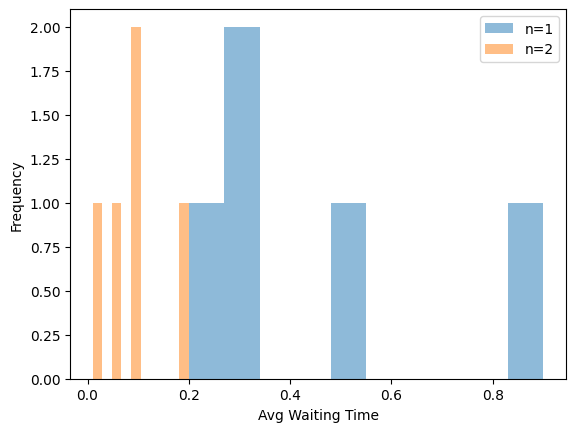

In [59]:
means_n1 = [0.5, 0.9, 0.3, 0.2, 0.3] # 1 mean is a the mean waiting time of a single run, one rho
means_n2 = [0.1 , 0.2, 0.1, 0.05, 0.01]

# Perform t-test
t_stat, p_val = stats.ttest_ind(means_n1, means_n2, equal_var=False)
print(t_stat)
print(p_val)

# plot histograms
# plot critical values on histogram
# plot confidence intervals on histogram

plt.hist(means_n1, alpha=0.5, label="n=1")
plt.hist(means_n2, alpha=0.5, label="n=2")
plt.legend()
plt.xlabel("Avg Waiting Time")
plt.ylabel("Frequency")